<a href="https://colab.research.google.com/github/michalis0/DataMining_and_MachineLearning/blob/master/week4/Linear_Regression_Deeper.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deeper understanding about linear regression and over-fitting

In this notebook we will take a deeper look into linear regression. We will see why in some cases augmenting the data with polynomial features help to get a more accurate model. Also we will see what does it mean when we say our model over-fits and cannot generalize well on unseen data.

## Packages

In [ ]:
# Import the libraries we will be using

import os
import numpy as np
import pandas as pd
import math
import matplotlib.pylab as plt
import seaborn as sns

%matplotlib inline
sns.set(style='ticks', palette='Set2')


## Motivational example

Imagine we have some noisy observations from a nonlinear function. We're going to approximate that function by fitting a polynomial to the observations. 

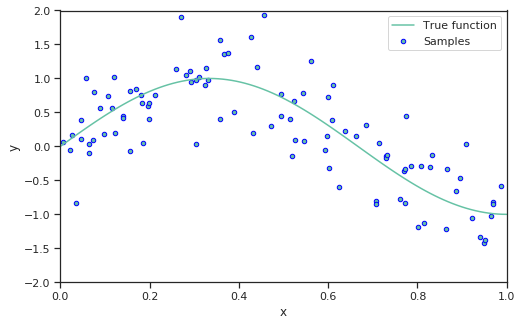

In [ ]:
num_samples = 100
# Set randomness so that we all get the same answer
np.random.seed(42)

def true_function(X):
    return np.sin(1.5 * np.pi * X)

def plot_example(X, Y, functions):
    # Get some X's to plot the functions
    X_test = pd.DataFrame(np.linspace(0, 1, 100), columns=['X'])
    # Plot stuff
    for key in functions:
        plt.plot(X_test, functions[key](X_test), label=key)
    plt.scatter(X, Y, edgecolor='b', s=20, label="Samples")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.xlim((0, 1))
    plt.ylim((-2, 2))
    plt.legend(loc="best")

# Add X in the range of [0, 1]
X = pd.DataFrame(np.sort(np.random.rand(num_samples)), columns=['x1'])
# Add some random noise to the observations
Y = true_function(X.x1) + np.random.randn(num_samples) * 0.5
# Plot stuff
functions = {"True function": true_function}
plt.figure(figsize=(8,5))
plot_example(X, Y, functions)
plt.show()

Let's assume that we don't know the true function, so we choose to model our noisy observations using linear regression. 

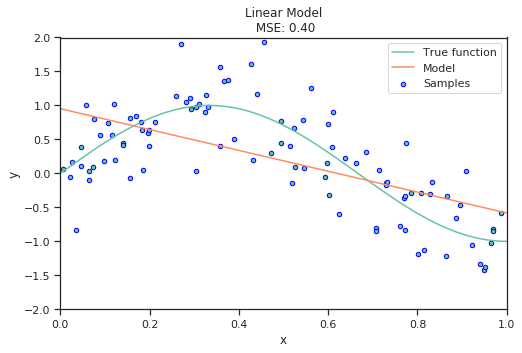

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Fit linear model
model = LinearRegression()
model.fit(X, Y)
# Evaluate model with mean squared error; just as an example
mse = mean_squared_error(Y, model.predict(X))
# Plot results
functions["Model"] = model.predict
plt.figure(figsize=(8,5))
plot_example(X, Y, functions)
#Note how you can customize your plots
plt.title("Linear Model\n MSE: %.2f" % mse)
plt.show()

Clearly the linear regression doesn't fit our data super well. Rather than trying a linear regression, let's attempt polynomial regression. How do different degree polynomials fit the data? Recall that a polynomial on a single variable looks like:

$$ a_1 + a_2 x + a_3 x^2 + ... $$

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures

def fit_polynomial(X, Y, degree):
    # create different powers of X
    polynomial_features = PolynomialFeatures(degree=degree, include_bias=False)
    linear_regression = LinearRegression()# we did't include bias, so we set fit_intercept as True
    pipeline = Pipeline([("polynomial_features", polynomial_features), ("linear_regression", linear_regression)])
    pipeline.fit(X, Y)
    return pipeline

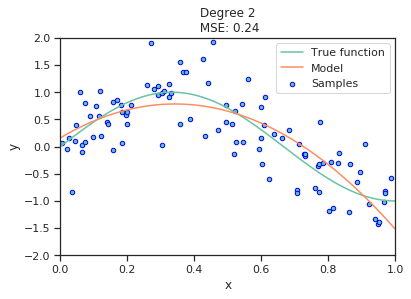

In [ ]:
def plot_poly(X, Y, degree):
    # Fit polynomial model
    model = fit_polynomial(X, Y, degree)
    # Evaluate model
    mse = mean_squared_error(Y, model.predict(X))
    # Plot results
    functions["Model"] = model.predict
    plt.title("Degree %d\n MSE: %.2f" % (degree, mse))
    plot_example(X, Y, functions)
    
plot_poly(X, Y, degree=2)
plt.show()

This seems to fit our data better than the purely linear model. What if we use polynomials with higher degrees?

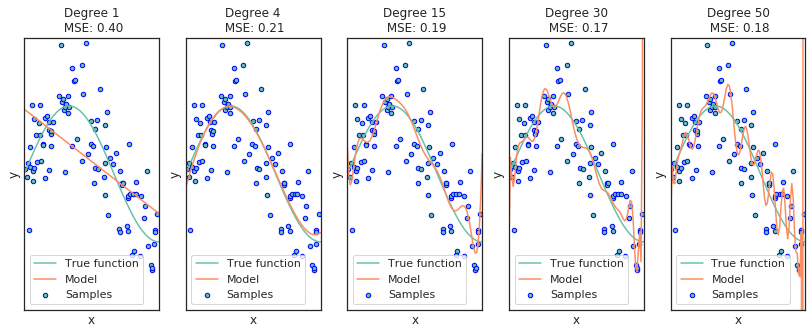

In [ ]:
plt.figure(figsize=(14, 5))
# degrees of the polynomial
degrees = [1, 4, 15, 30, 50]
for i in range(len(degrees)):
    ax = plt.subplot(1, len(degrees), i + 1)
    plt.setp(ax, xticks=(), yticks=())
    plot_poly(X, Y, degrees[i])
plt.show()

let's see the effect of increasing polynomial degree through train/test error

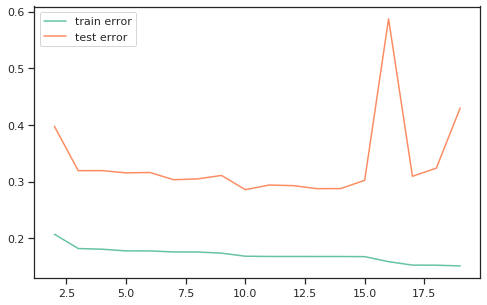

In [ ]:
from sklearn.model_selection import train_test_split
X_train , X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=10)
tr_errors=[]
te_errors=[]
for d in range(2, 20):
    # Fit polynomial model
    model = fit_polynomial(X_train, Y_train, d)
    # Evaluate model
    mse_train = mean_squared_error(Y_train, model.predict(X_train))
    mse_test = mean_squared_error(Y_test, model.predict(X_test))
    tr_errors.append(mse_train)
    te_errors.append(mse_test)
    
plt.figure(figsize=(8,5))
plt.plot(range(2,20), tr_errors, label="train error")
plt.plot(range(2,20), te_errors, label="test error")
plt.legend()

We use a regularized model for the polynomial of degree 10. We will use cross validation

In [ ]:
from sklearn.linear_model import RidgeCV
polynomial_features = PolynomialFeatures(degree=10, include_bias=False)
X_poly = polynomial_features.fit_transform(X)
ridge = RidgeCV()
ridge.fit(X_poly, Y)

RidgeCV(alphas=array([ 0.1,  1. , 10. ]), cv=None, fit_intercept=True,
        gcv_mode=None, normalize=False, scoring=None, store_cv_values=False)

In [ ]:
# best regularizer parameter
ridge.alpha_

0.1